In [1]:
# Upgrade the Transformers library to the latest version
# !pip install -U transformers

# Upgrade Transformers and Datasets libraries, and set a specific version of fsspec for compatibility
!pip install -U transformers datasets fsspec==2023.6.0

# Install the latest versions of the Hugging Face Transformers and Datasets libraries
!pip install -q transformers datasets

# Install the 'evaluate' library used for model evaluation (e.g. BLEU, ROUGE, etc.)
!pip install -q evaluate

# Install specific libraries used for text evaluation metrics:
!pip install -q rouge_score nltk sacrebleu

# Install 'wordcloud' library used for visualisation of most frequent words
!pip install -q wordcloud



     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.9/40.9 kB 1.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 163.8/163.8 kB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.8/10.8 MB 104.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.5/491.5 kB 35.3 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
  Attempting uninstall: transformers
    Found existing installation: transformers 4.53.0
    Uninstalling transformers-4.53.0:
      Successfully uninstalled transformers-4.53.0
  Attempting uninstall: datasets
    Found existing installation: datasets 2.14.4
    Uninstalling datasets-2.14.4:
      Successfully uninstalled datasets-2.14.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
t

In [2]:
# Import Statements
import transformers
from datasets import load_dataset
from transformers import (
    AutoTokenizer,
    AutoModelForSeq2SeqLM,
    Seq2SeqTrainingArguments,
    Seq2SeqTrainer,
    DataCollatorForSeq2Seq
)
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import torch
import os
import evaluate
import numpy as np
import pandas as pd

In [3]:
# Print Transformer version
print(transformers.__version__)


4.53.1


In [4]:
# Mount google drive to collab
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive



## Dataset Section

This cell loads the OPUS Books dataset for German-English (de-en) translation using the Hugging Face `datasets` library.

Steps:
- Loads the 'de-en' split of the OPUS Books dataset.
- Prints the structure of the dataset to show available splits and metadata.
- Displays 5 randomly shuffled examples from the training set using a fixed seed for reproducibility.

Purpose:
This section provides a quick look at the dataset's structure and sample contents,
helpful for verifying data quality and preparing for preprocessing or model training.



In [5]:
# Load the Dataset
dataset = load_dataset("opus_books", "de-en")



/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/8.80M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/51467 [00:00<?, ? examples/s]

In [6]:
# dataset structure
print(dataset)

# Show few samples
examples = dataset["train"].shuffle(seed=42).select(range(5))

# Print Examples
print(examples)

DatasetDict({
    train: Dataset({
        features: ['id', 'translation'],
        num_rows: 51467
    })
})
Dataset({
    features: ['id', 'translation'],
    num_rows: 5
})



## Exploratory Data Analysis (EDA): Sentence Characteristics and Word Usage

This section performs exploratory data analysis (EDA) on the OPUS Books German-English translation dataset,
focusing on sentence length distribution and frequent word usage.

### Part 1: Sentence Length Distribution
- Calculates the number of words per sentence for both German (source) and English (target) translations in the training set.
- Plots overlapping histograms to visualize and compare sentence length distributions.
- Adds axis labels, legend, grid, and saves the figure as a high-resolution PNG image.
- This helps understand the variability and typical lengths of translation pairs, which is useful for padding, batching, and model input limits.

### Part 2: Word Cloud Visualization
- Joins all German and English sentences into two large strings.
- Generates word clouds using the `WordCloud` library to visualize the most frequent words in both languages.
- Displays the German and English word clouds side by side for visual comparison.
- Saves the final figure as a PNG image.

These visualizations provide quick, intuitive insights into the dataset's structure, content, and common vocabulary patterns.



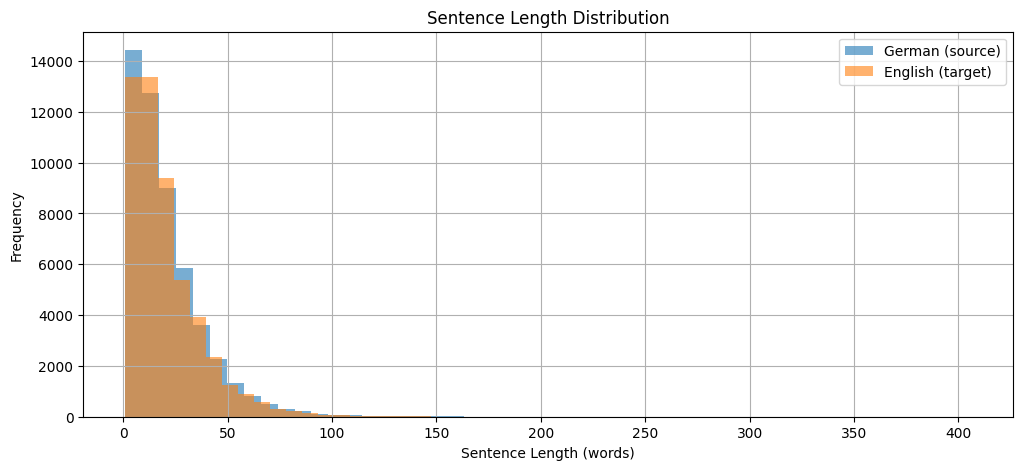

In [7]:

# Get sentence lengths for source and target
src_lengths = [len(example["translation"]["de"].split()) for example in dataset["train"]]
tgt_lengths = [len(example["translation"]["en"].split()) for example in dataset["train"]]

# Plot histograms of sentence lengths for source (German) and target (English) texts

# Create a new figure with specified size
plt.figure(figsize=(12, 5))

# Plot histogram of German sentence lengths
plt.hist(src_lengths, bins=50, alpha=0.6, label="German (source)")

# Plot histogram of English sentence lengths
plt.hist(tgt_lengths, bins=50, alpha=0.6, label="English (target)")

# Label the x-axis and y-axis
plt.xlabel("Sentence Length (words)")
plt.ylabel("Frequency")

# Set the title of the plot
plt.title("Sentence Length Distribution")

# Add legend and grid for better readability
plt.legend()
plt.grid(True)

# Save the figure
plt.savefig("/content/drive/MyDrive/Sentence_Length.png", dpi=300, bbox_inches='tight')

# Show the plot
plt.show()


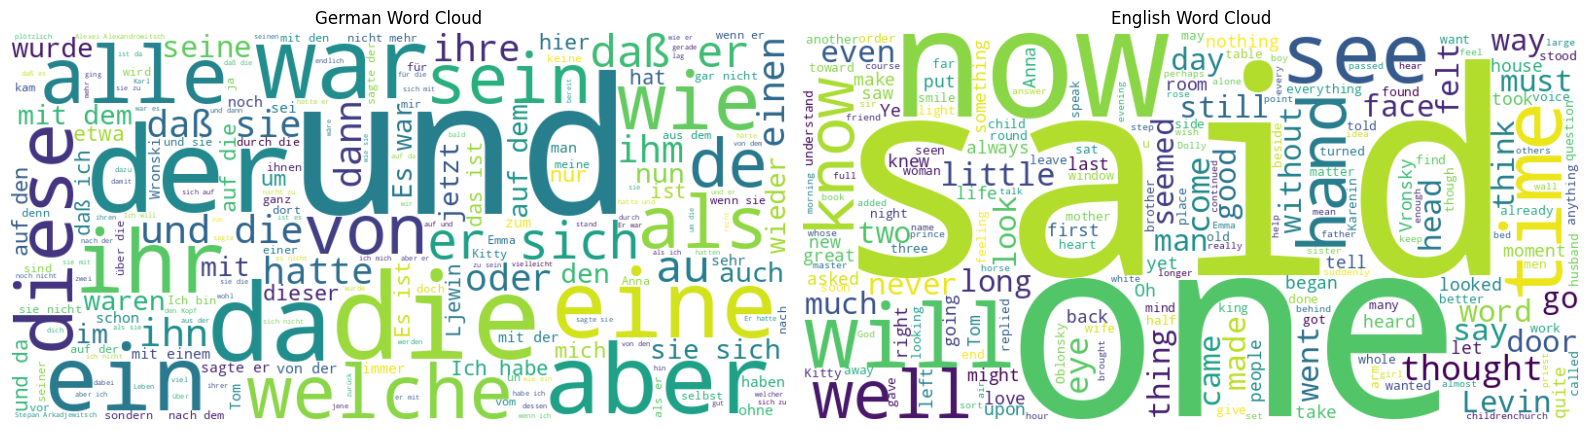

In [8]:
# Join all German and English sentences into single strings
german_text = " ".join([example["translation"]["de"] for example in dataset["train"]])
english_text = " ".join([example["translation"]["en"] for example in dataset["train"]])

# Create WordCloud objects for German and English
german_wc = WordCloud(width=800, height=400, background_color='white').generate(german_text)
english_wc = WordCloud(width=800, height=400, background_color='white').generate(english_text)

# Plot both word clouds side by side
plt.figure(figsize=(16, 8))

# German word cloud
plt.subplot(1, 2, 1)
plt.imshow(german_wc, interpolation='bilinear')
plt.axis('off')
plt.title("German Word Cloud")

# English word cloud
plt.subplot(1, 2, 2)
plt.imshow(english_wc, interpolation='bilinear')
plt.axis('off')
plt.title("English Word Cloud")

plt.tight_layout()
plt.savefig("/content/drive/MyDrive/wordclouds.png", dpi=300, bbox_inches='tight')  # Optional: save
plt.show()


In [9]:
# Load T5 Tokenizer & Model
model_checkpoint = "t5-small"
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)
model = AutoModelForSeq2SeqLM.from_pretrained(model_checkpoint)


tokenizer_config.json:   0%|          | 0.00/2.32k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.39M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.21k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/242M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

In [10]:
# Set the device to GPU (CUDA) if available, otherwise fall back to CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Move the model to the selected device (GPU or CPU)
model.to(device)


T5ForConditionalGeneration(
  (shared): Embedding(32128, 512)
  (encoder): T5Stack(
    (embed_tokens): Embedding(32128, 512)
    (block): ModuleList(
      (0): T5Block(
        (layer): ModuleList(
          (0): T5LayerSelfAttention(
            (SelfAttention): T5Attention(
              (q): Linear(in_features=512, out_features=512, bias=False)
              (k): Linear(in_features=512, out_features=512, bias=False)
              (v): Linear(in_features=512, out_features=512, bias=False)
              (o): Linear(in_features=512, out_features=512, bias=False)
              (relative_attention_bias): Embedding(32, 8)
            )
            (layer_norm): T5LayerNorm()
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (1): T5LayerFF(
            (DenseReluDense): T5DenseActDense(
              (wi): Linear(in_features=512, out_features=2048, bias=False)
              (wo): Linear(in_features=2048, out_features=512, bias=False)
              (dropout): Drop


## Preprocessing: Tokenization for Translation Model

This section defines and applies a preprocessing function to prepare the German-English dataset
for training a sequence-to-sequence translation model.

### Function: `preprocess_function`
- Converts each German sentence into a prompt format: `"translate German to English: <sentence>"`.
- Extracts the corresponding English translation as the target.
- Uses a tokenizer to encode both the input and target sentences:
  - Applies truncation and padding to a maximum length of 128 tokens.
  - Returns input IDs and attention masks for both source and target texts.
- The tokenized English targets are added to the model inputs under the `"labels"` key, which is required for supervised training.

### Application:
- The `dataset.map()` function is used with `batched=True` to efficiently apply the preprocessing function to the full dataset.
- The output is stored as `tokenized_dataset`, which is ready to be fed into a transformer-based translation model.

This step ensures uniform input format and length, enabling efficient training and batching.



In [11]:
def preprocess_function(example):
    """
    Preprocesses a batch of translation examples for input into a seq2seq model.

    This function:
    - Formats the German source sentence with a translation prefix expected by the model.
    - Tokenizes both the source (German) and target (English) sentences using the provided tokenizer.
    - Applies padding and truncation to a maximum length of 128 tokens.
    - Adds the tokenized target sentences as labels for supervised training.

    Args:
        example (dict): A batch of examples with 'translation' dictionaries
                        containing 'de' (German) and 'en' (English) keys.

    Returns:
        dict: A dictionary containing tokenized inputs and labels suitable for model training.
    """
    # Prepare input strings for translation in the format expected by the model
    inputs = [f"translate German to English: {ex['de']}" for ex in example["translation"]]

    # Extract the corresponding English target sentences
    targets = [ex["en"] for ex in example["translation"]]

    # Tokenize the input sentences with truncation and padding to max length of 128 tokens
    model_inputs = tokenizer(inputs, max_length=128, truncation=True, padding="max_length")

    # Tokenize the target (English) sentences similarly
    labels = tokenizer(targets, max_length=128, truncation=True, padding="max_length")

    # Add tokenized target sentences to the model inputs under the "labels" key
    model_inputs["labels"] = labels["input_ids"]

    return model_inputs


# This will create the `tokenized_dataset`
tokenized_dataset = dataset.map(preprocess_function, batched=True)


Map:   0%|          | 0/51467 [00:00<?, ? examples/s]

In [12]:
# Split train into 90% train, 10% validation
train_val = tokenized_dataset["train"].train_test_split(test_size=0.1, seed=42)

train_dataset = train_val["train"]
eval_dataset = train_val["test"]


In [13]:
# Data Collator
data_collator = DataCollatorForSeq2Seq(tokenizer=tokenizer, model=model)



## Model Implementation and Training

This section defines and executes the training process for a sequence-to-sequence translation model using Hugging Face's `Seq2SeqTrainer`.

### Key Components:

1. **Disable Weights & Biases Logging:**
   - Turns off W&B experiment tracking to prevent automatic logging.

2. **Training Configuration (`Seq2SeqTrainingArguments`):**
   - Specifies output directory for model checkpoints.
   - Sets evaluation frequency (`eval_steps`), learning rate, batch sizes, and weight decay.
   - Enables mixed-precision training (`fp16`) for performance boost on supported hardware.
   - Defines logging and saving strategies to control training diagnostics and model checkpoints.
   - Enables text generation (`predict_with_generate`) during evaluation for sequence-to-sequence tasks.

3. **Trainer Initialization (`Seq2SeqTrainer`):**
   - Combines model, tokenizer, datasets, and data collator into a unified training interface.
   - Handles training loop, evaluation, logging, and checkpointing internally.

4. **Start Training:**
   - Launches the training process using `.train()` based on the configurations.

This setup provides a robust, scalable training pipeline for transformer-based model T5-small on translation tasks.



In [14]:
# Disable Weights & Biases logging (to avoid unwanted experiment tracking/logging)
os.environ["WANDB_DISABLED"] = "true"

# Define training arguments for the Seq2SeqTrainer
training_args = Seq2SeqTrainingArguments(
    # Directory to save model checkpoints and final model
    output_dir="/content/drive/MyDrive/t5_translation_model",

    # Evaluate the model every few steps instead of at the end of each epoch
    eval_strategy="steps",
    eval_steps=500,  # Run evaluation every 500 training steps

    # Set the learning rate for the optimizer
    learning_rate=1e-5,

    # Batch size per device during training and evaluation
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,

    # Apply weight decay for regularization to reduce overfitting
    weight_decay=0.01,

    # Limit the total number of saved checkpoints to avoid filling disk space
    save_total_limit=2,

    # Number of epochs to train the model
    num_train_epochs=3,

    # Enable text generation during evaluation
    predict_with_generate=True,

    # Enable mixed precision training for faster performance on supported GPUs
    fp16=True,

    # Directory to store training logs
    logging_dir='/content/drive/MyDrive/t5_logs',

    # Log training info every few steps
    logging_strategy="steps",
    logging_steps=100,

    # Save a checkpoint every 1000 steps
    save_steps=1000
)


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


In [15]:
# Initialize the Seq2SeqTrainer for training and evaluating the model
trainer = Seq2SeqTrainer(
    model=model,                         # The model to train
    args=training_args,                  # Training configuration defined earlier
    train_dataset=train_dataset,         # Dataset used for training
    eval_dataset=eval_dataset,           # Dataset used for evaluation
    tokenizer=tokenizer,                 # Tokenizer for preprocessing text inputs/outputs
    data_collator=data_collator,         # Function to batch and pad data samples
)


/tmp/ipython-input-15-2369195313.py:2: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Seq2SeqTrainer.__init__`. Use `processing_class` instead.
  trainer = Seq2SeqTrainer(


In [16]:
# Start the model training using the specified trainer configuration
trainer.train()


Passing a tuple of `past_key_values` is deprecated and will be removed in Transformers v4.48.0. You should pass an instance of `EncoderDecoderCache` instead, e.g. `past_key_values=EncoderDecoderCache.from_legacy_cache(past_key_values)`.


Step,Training Loss,Validation Loss
500,1.074900,0.911909
1000,0.893400,0.781897
1500,0.834000,0.750990
2000,0.822900,0.735793
2500,0.805500,0.725984
3000,0.815700,0.718885
3500,0.782000,0.712433
4000,0.820000,0.707559
4500,0.786500,0.703359
5000,0.779600,0.700021


TrainOutput(global_step=17370, training_loss=0.854985730923931, metrics={'train_runtime': 1939.8333, 'train_samples_per_second': 71.635, 'train_steps_per_second': 8.954, 'total_flos': 4701774183137280.0, 'train_loss': 0.854985730923931, 'epoch': 3.0})


## Model Evaluation: Training Analysis, Inference, and Metric-Based Assessment

This section evaluates the performance of the trained translation model using multiple methods:
visual inspection of training progress, qualitative output samples, and quantitative metric evaluation.

### Part 1: Training & Evaluation Loss Visualization
- Extracts the training and evaluation loss values from `trainer.state.log_history`.
- Computes training loss using a moving average to reduce noise.
- Plots both training loss and validation loss across training steps.
- Saves the loss curve as a high-resolution PNG image.

### Part 2: Inference Function (`translate`)
- Defines a `translate()` function to generate English translations from German input using the trained model.
- Prepares the input prompt in the format expected by the model.
- Tokenizes the input, moves it to the appropriate device, and generates an output sequence.
- Decodes and returns the translated English sentence.
- Includes example usage on common German phrases to demonstrate the model’s output quality.

### Part 3: Metric-Based Evaluation
- Loads standard machine translation metrics using the `evaluate` library:
  - **BLEU**: N-gram precision overlap
  - **ROUGE-L**: Longest common subsequence (recall-focused)
  - **METEOR**: Considers synonyms and stems
  - **ChrF**: Character n-gram F-score, helpful for morphologically rich languages
- Defines `evaluate_translation()` to compute metric scores on a sample of 100 examples from the evaluation dataset.
- Generates predictions, formats references appropriately for each metric, and computes scores.
- Prints the final evaluation scores with two-decimal precision.

This evaluation section ensures a comprehensive understanding of model performance from both human-readable and statistically measurable perspectives.



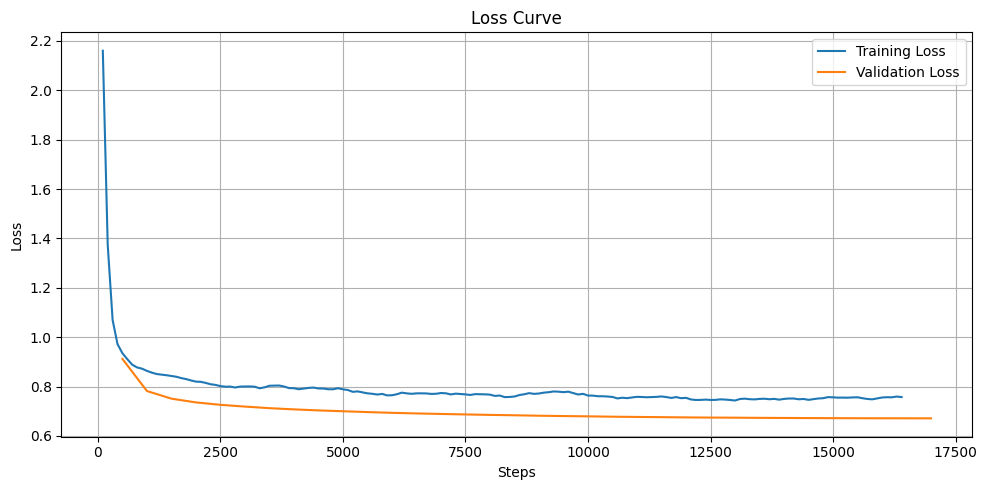

In [17]:
# Extract training history
train_logs = trainer.state.log_history

# Separate into lists
steps = [log["step"] for log in train_logs if "loss" in log]
train_loss = [log["loss"] for log in train_logs if "loss" in log]
eval_steps = [log["step"] for log in train_logs if "eval_loss" in log]
eval_loss = [log["eval_loss"] for log in train_logs if "eval_loss" in log]



# Define a function to compute the moving average of a list of values
def moving_average(values, window=5):
    return np.convolve(values, np.ones(window)/window, mode='valid')

# Apply moving average smoothing to the training loss values using a window size of 10
smoothed_train_loss = moving_average(train_loss, window=10)

# Adjust the step values to match the length of the smoothed loss array
smoothed_steps = steps[:len(smoothed_train_loss)]

# Create a plot to visualize the smoothed training loss and validation loss
plt.figure(figsize=(10, 5))  # Set the figure size

# Plot the smoothed training loss curve
plt.plot(smoothed_steps, smoothed_train_loss, label="Training Loss")

# Plot the validation loss curve at evaluation steps
plt.plot(eval_steps, eval_loss, label="Validation Loss")

# Label the axes and title the plot
plt.xlabel("Steps")
plt.ylabel("Loss")
plt.title("Loss Curve")

# Add legend and grid for better readability
plt.legend()
plt.grid(True)

# Automatically adjust subplot params to fit in the figure area
plt.tight_layout()

# Save the Figure
plt.savefig("/content/drive/MyDrive/loss_curve.png", dpi =300, bbox_inches='tight' )

# Display the final plot
plt.show()


In [18]:
# Define a function to translate a German sentence into English using the trained model
def translate(text):
    """
    Translates a German sentence into English using the trained sequence-to-sequence model.

    This function:
    - Formats the input text using the prompt style expected by the model.
    - Tokenizes and sends the input to the appropriate device (CPU or GPU).
    - Generates the translated output with a max length of 128 tokens.
    - Decodes the generated token IDs into a readable English sentence.

    Args:
        text (str): A sentence in German to be translated.

    Returns:
        str: The English translation generated by the model.
    """
    # Format the input text with the prefix expected by the model
    input_text = f"translate German to English: {text}"

    # Tokenize the input text and convert it to PyTorch tensors, move to the model's device (CPU/GPU)
    inputs = tokenizer(input_text, return_tensors="pt", truncation=True, padding=True).to(model.device)

    # Generate the translation using the model with a maximum output length of 128 tokens
    outputs = model.generate(**inputs, max_length=128)

    # Decode the generated token IDs to a readable English sentence, skipping special tokens
    return tokenizer.decode(outputs[0], skip_special_tokens=True)

# Example usage of the translate function:

print(translate("Das ist ein einfaches Beispiel."))

print(translate("Ich liebe maschinelles Lernen."))

print(translate("Wie spät ist es?"))

print(translate("Können Sie mir bitte helfen?"))



It is a simple example.
I love to learn.
How late is it?
Is it possible to help me?


In [19]:
# Load common translation evaluation metrics from the `evaluate` library
bleu = evaluate.load("bleu")       # BLEU: measures n-gram overlap between prediction and reference
rouge = evaluate.load("rouge")     # ROUGE: common in summarization, measures recall of word sequences
meteor = evaluate.load("meteor")   # METEOR: considers synonyms and stemming, more linguistically informed
chrf = evaluate.load("chrf")       # ChrF: character n-gram F-score, useful for morphologically rich languages

# Define a function to evaluate the model's translation quality on a sample of the evaluation dataset
def evaluate_translation(model, tokenizer, eval_dataset, sample_size=100):
    """
    Evaluates the translation quality of a trained model using standard metrics.

    This function:
    - Selects a subset of examples from the evaluation dataset.
    - Uses the `translate` function to generate English predictions for each German sentence.
    - Formats the ground truth references to match the input format expected by evaluation metrics.
    - Computes BLEU, ROUGE-L, METEOR, and ChrF scores.
    - Returns the results as a dictionary.

    Args:
        model: The trained translation model used for generating predictions.
        tokenizer: Tokenizer associated with the model for input/output processing.
        eval_dataset: Hugging Face Dataset containing translation examples for evaluation.
        sample_size (int, optional): Number of examples to evaluate. Defaults to 100.

    Returns:
        dict: A dictionary containing the computed metric scores:
              - "BLEU": BLEU score (0–100)
              - "ROUGE-L": ROUGE-L score
              - "METEOR": METEOR score (0–100)
              - "CHRF": ChrF score
    """
    # Select a subset of examples from the evaluation dataset for quick evaluation
    examples = eval_dataset.select(range(sample_size))

    # Generate translations for each German input in the selected examples
    predictions = [translate(example["translation"]["de"]) for example in examples]

    # Prepare references in the format required by each metric
    references = [[example["translation"]["en"]] for example in examples]   # Nested for BLEU & METEOR
    flat_references = [ref[0] for ref in references]                        # Flat for ROUGE & CHRF

    # Compute and store evaluation results in a dictionary
    results = {}
    results["BLEU"] = bleu.compute(predictions=predictions, references=references)["bleu"] * 100
    results["ROUGE-L"] = rouge.compute(predictions=predictions, references=flat_references)["rougeL"]
    results["METEOR"] = meteor.compute(predictions=predictions, references=flat_references)["meteor"] * 100
    results["CHRF"] = chrf.compute(predictions=predictions, references=flat_references)["score"]

    return results  # Return the dictionary containing all computed metric scores


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


In [20]:
# Run the evaluation function to compute translation quality metrics on the evaluation dataset
results = evaluate_translation(model, tokenizer, eval_dataset)

# Loop through each metric and print its score, formatted to two decimal places
for metric, score in results.items():
    print(f"{metric}: {score:.2f}")


BLEU: 6.25
ROUGE-L: 0.28
METEOR: 27.28
CHRF: 26.28


In [21]:
# Save the final trained model to the directory
trainer.save_model("/content/drive/MyDrive/t5_translation_model/final_model")

# Save the tokenizer files to the same directory
tokenizer.save_pretrained("/content/drive/MyDrive/t5_translation_model/final_model")


('/content/drive/MyDrive/t5_translation_model/final_model/tokenizer_config.json',
 '/content/drive/MyDrive/t5_translation_model/final_model/special_tokens_map.json',
 '/content/drive/MyDrive/t5_translation_model/final_model/spiece.model',
 '/content/drive/MyDrive/t5_translation_model/final_model/added_tokens.json',
 '/content/drive/MyDrive/t5_translation_model/final_model/tokenizer.json')


## Output Inspection: Translation Result Comparison

This section generates and displays side-by-side comparisons of the model's predicted translations
against the reference (ground truth) translations.

### Steps:
- Iterates through a set of evaluation examples.
- For each example:
  - Extracts the source sentence in German.
  - Retrieves the ground truth English translation.
  - Generates the predicted translation using the trained model via the `translate()` function.
- Stores the original German sentence, reference translation, and model output in a structured format.
- Converts the results into a Pandas DataFrame for clean, tabular visualization.

This step provides a qualitative view of translation performance, allowing users to spot errors,
assess fluency, and understand strengths or weaknesses in specific examples.



In [22]:
# Show some example translations from the training dataset

# Randomly shuffle the training data and select the first 5 examples for demonstration
examples = dataset["train"].shuffle(seed=1).select(range(5))

# Initialize a list to store the results
results = []

# Loop through each selected example
for example in examples:
    src = example["translation"]["de"]       # Source sentence in German
    tgt = example["translation"]["en"]       # Ground truth translation in English
    pred = translate(src)                    # Predicted translation using the model

    # Store the source, reference, and predicted translation in a dictionary
    results.append({"German": src, "Reference": tgt, "Predicted": pred})

# Display the results in a clean, tabular format using pandas
pd.DataFrame(results)


,German,Reference,Predicted
0,Nimm dich in acht!«,Now be careful...',Nimm dich in acht!'
1,"K. tat, als hätte er ihr Benehmen nicht bemerk...",K. pretended not to notice her behaviour and a...,"K. sat, as if he had not been aware of her, an..."
2,"Ich bin stolz auf meine Lage, weil ... Ich bin...",I am proud of my position because... proud of....,"I am proud of my position, because... I am pro..."
3,Aber nun nahm sie plötzlich meinen Schleier vo...,But presently she took my veil from its place;...,But she jumped suddenly from his place; she sa...
4,Bald hörte sie deutlich das Rasseln der Räder ...,One could distinguish the noise of a carriage ...,Bald listened to the smears of the smear of th...
